In [5]:
#import sys
#sys.path.append('./py_files')
import speech_rate
import performance_measures
from collections import defaultdict
import os
import glob
import re
import numpy as np
from collections import defaultdict
from pandas import DataFrame
from IPython.display import HTML
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import *
from plotly.tools import FigureFactory as ff
from decimal import *
getcontext()
getcontext().prec = 2
TWOPLACES = Decimal(10) ** -2 

In [2]:
# Returns a dictionary of phoneme occurences (keys) in the training data and their durations (values), and LSR (values)
# Looks like {a: [1452, 0.8, 799, 0.5], b : [655, 0.5, 799, 0.45]...}
def read_trainig_files():
	training_dict = defaultdict(list)
	os.chdir("C:/Users/alexutza_a/Abschlussarbeit/DB_Verbmobil/Evaluation/Training")
	
	#Iterate over the training files
	for file in glob.glob("*.par"):
		work_file = open(file)

		for line in work_file:
			if re.match("MAU", line):
				training_dict[line.split()[4]].append(int(line.split()[2]))
				word_duration, phon_count, syl_count = speech_rate.word_duration(file, int(line.split()[3]))
				training_dict[line.split()[4]].append((word_duration/0.0000625)/phon_count) # speech rate as time/phon
				#training_dict[line.split()[4]].append(speech_rate.local_speech_rate(file, int(line.split()[3])))

		work_file.close()
	
	# Remove breaks from the data
	x = training_dict.pop("<p:>")

	return training_dict
#read_trainig_files()

In [3]:
# A dictionary giving the values of Mean and SD in a list for each encountered phoneme.
def phone_stats(training_dict):
	stat_dict = defaultdict(list)

	for phoneme in training_dict.keys():
		stat_dict[phoneme].append(int(round(np.mean(training_dict[phoneme][::2]), 0)))
		stat_dict[phoneme].append(int(round(np.std(training_dict[phoneme][::2]), 0)))

	return stat_dict

In [4]:
# Returns a list of phoneme occuring in the test files, followed by their respective durations
# Looks like: ["a", 583, 0.5, "b", 12, 0.78, "a", 489, 0.12, ...]
def read_testfiles():
	compare_list = []
	os.chdir("C:/Users/alexutza_a/Abschlussarbeit/DB_Verbmobil/Evaluation/Test")

	#Iterate over the test files
	for file in glob.glob("*.par"):
		work_file = open(file)

		for line in work_file:
			if re.match("MAU", line):
				compare_list.append(str(line.split()[4]))
				compare_list.append(int(line.split()[2]))
				word_duration, phon_count, syl_count = speech_rate.word_duration(file, int(line.split()[3]))
				#compare_list.append((word_duration/0.0000625)/phon_count) # speech rate as word_duration / # phonemes
				compare_list.append(speech_rate.local_speech_rate(file, int(line.split()[3])))
		work_file.close()
	#print(compare_list)
	# Remove breaks from the data

	# Get list of indexes for occurences of <p:>
	pause_index = [i for i, val in enumerate(compare_list) if val == "<p:>"]
	#print(len(pause_index))
	pause_dur = [i + 1  for i in pause_index]
	pause_stat = [j + 1  for j in pause_dur]
	p_l = [x for y in zip (pause_index, pause_dur) for x in y]
	p_list = p_l + pause_stat
	#print(len(p_list))
	actual_list = []

	#print(compare_list)
	ind = 0
	# Copy list to new list, without pauses
	for el in compare_list:
		if ind not in p_list:
			actual_list.append(el)
		ind += 1

	return actual_list

In [5]:
# Quote of phoneme mean duration being greater than the local speech rate (as word duration / no. of phonemes)
def test_mean(training_dict, stat_dict):
	test_dict = defaultdict(float)

	for elem in training_dict.keys():
		rate_list = training_dict[elem][1::2]
		test_mean_list = [ 1 for x in rate_list if x <= stat_dict[elem][0]]
		test_dict[elem] = len(test_mean_list)/len(rate_list)
	return test_dict
DataFrame.from_dict(test_mean(read_trainig_files(), phone_stats(read_trainig_files())), orient="index")

,0
j,0.0
a:,0.0
g,0.0
u:,0.0
n,0.0
t,0.0
k,0.0
h,0.0
E,0.0
6,0.0


Pearson correlation coefficient:0.653359218023


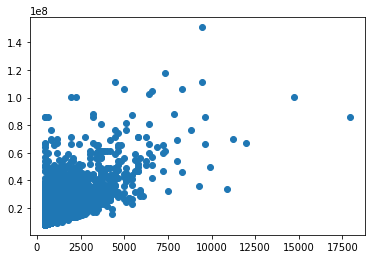

In [6]:
# Create a list of durations and a list of word durations from the training data
def dur_vs_rate(training_dict):
    duration_list = []
    rate_list = []
    for el in training_dict.keys():
        duration_list += training_dict[el][::2]
        rate_list += training_dict[el][1::2]
    return duration_list, rate_list
duration_list, rate_list = dur_vs_rate(read_trainig_files())

# Calculate the Pearson corrCoef for phoneme duration vs speech rate as word_dur / no. of phones
print("Pearson correlation coefficient:" + str(pearsonr(duration_list, rate_list)[0]))

# Plot phoneme duration vs. speech rate as word_dur / no. of phones
plt.scatter(duration_list, rate_list)
plt.show()

In [7]:
# Plot only diphthongs
diph_list = ["aI", "aU", "OY"]
diph_dict = {key:read_trainig_files()[key] for key in diph_list}
diph_dict = {"aI":read_trainig_files()["aI"]}
dur_aI, rate_aI = dur_vs_rate(diph_dict)
diph_dict = {"aU":read_trainig_files()["aU"]}
dur_aU, rate_aU = dur_vs_rate(diph_dict)
diph_dict = {"OY":read_trainig_files()["OY"]}
dur_OY, rate_OY = dur_vs_rate(diph_dict)

# Calculate the Pearson corrCoef for phoneme duration vs speech rate as word_dur / no. of phones
print("Pearson correlation coefficient:\n" + 
      "All diphthongs: " + str(pearsonr(duration_list, rate_list)[0]) + "\n"
     + "aI: " + str(pearsonr(dur_aI, rate_aI)[0]) + "\naU: " + str(pearsonr(dur_aU, rate_aU)[0])
     + "\nOY: " + str(pearsonr(dur_OY, rate_OY)[0]))


# Plot phoneme duration vs. speech rate as word_dur / no. of phones
aI = plt.scatter(dur_aI, rate_aI, color = "red")
aU = plt.scatter(dur_aU, rate_aU, color = "blue")
OY = plt.scatter(dur_OY, rate_OY, color = "green")
mpl_fig = plt.gcf()

plotly_fig = tls.mpl_to_plotly( mpl_fig )
py.iplot(plotly_fig)

Pearson correlation coefficient:
All diphthongs: 0.653359218023
aI: 0.619208900401
aU: 0.476747240079
OY: 0.775621668637


In [4]:
# Get a vowel dict. of all data
# Create plots for showing correlations between phoneme duration and different types of SR calculation, using all data
import phon_dict

long_vowels = ["a:", "e:", "E:", "i:", "o:", "u:", "2:", "y:"]
short_front_vowels = ["a", "O", "o", "u", "U"]
short_back_mid_vowels = ["E", "9", "e", "2"]
short_back_vowels = ["i", "I", "y", "Y"]

big_dict = phon_dict.phon_dict(short_back_mid_vowels)

In [8]:
overall_duration_list, new_SR_list, msyl_list, LSR_list, PSR_list = [], [], [], [], []
print(big_dict["E"][:65])
for el in short_back_mid_vowels:
    overall_duration_list += big_dict[el][13::14]
    new_SR_list += big_dict[el][10::14]
    msyl_list += big_dict[el][9::14]
    LSR_list += big_dict[el][8::14]
    PSR_list += big_dict[el][7::14]
print(new_SR_list[:15])

['E', 'g001acn1_000_AAJ.par', 'Middle_word', 'NN', 'no_pause', 'none', '0', 13.9, 2.8, 6.2, 0.003, 1, 'one_s', 479, 'E', 'g001acn1_000_AAJ.par', 'Middle_word', 'NE', 'no_pause', 'none', '0', 13.9, 0.9, 6.2, 0.0072, 1, 'w_initial', 639, 'E', 'g001acn1_000_AAJ.par', 'Middle_word', 'NN', 'no_pause', 'none', '0', 13.9, 0.9, 6.2, 0.0082, 1, 'w_initial', 1119, 'E', 'g001acn1_000_AAJ.par', 'Middle_word', 'VVFIN', 'no_pause', 'none', '0', 13.9, 0.9, 6.2, 0.0085, 1, 'w_initial', 479, 'E', 'g001acn1_002_AAJ.par', 'Start_word', 'ADJD', 'no_pause', 'none', '0', 7.5, 0.4]
[0.003, 0.0072, 0.0082, 0.0085, 0.014, 0.004, 0.0065, 0.0085, 0.0062, 0.0057, 0.0125, 0.0132, 0.0065, 0.0068, 0.005]


Long vowel duration vs. SR (word_dur / no of phones) 
Pearson CorrCoef: (0.40085550052587499, 0.0)


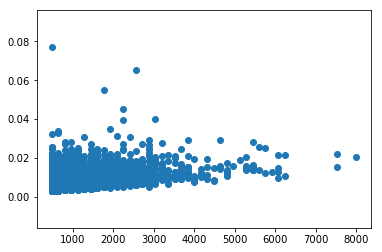

Long vowel duration vs. SR (MAU-Syllables / turn duration) 
Pearson CorrCoef: (-0.12696679200673711, 3.2851089818542128e-58)


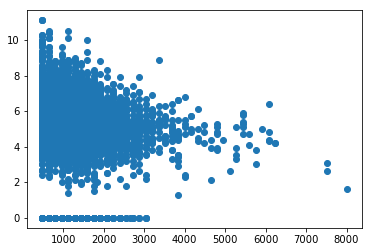

Long vowel duration vs. local speech rate (LSR) 
Pearson CorrCoef: (-0.42525984959841351, 0.0)


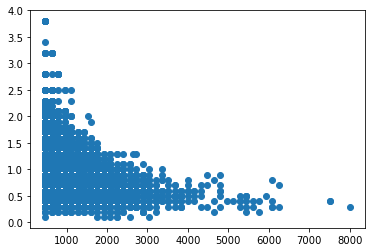

Long vowel duration vs. SR (no of phonemes / turn duration) 
Pearson CorrCoef: (-0.11134897304379225, 4.2187235896266637e-45)


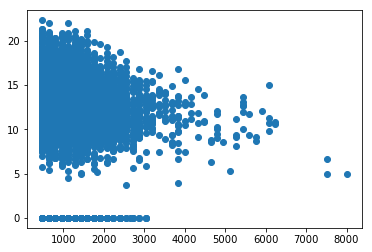

In [9]:
print("Long vowel duration vs. SR (word_dur / no of phones) \nPearson CorrCoef: " + str(performance_measures.corrCoef(overall_duration_list, new_SR_list)))
plt.scatter(overall_duration_list, new_SR_list)
plt.show()

print("Long vowel duration vs. SR (MAU-Syllables / turn duration) \nPearson CorrCoef: " + str(performance_measures.corrCoef(overall_duration_list, msyl_list)))
plt.scatter(overall_duration_list, msyl_list)
plt.show()

print("Long vowel duration vs. local speech rate (LSR) \nPearson CorrCoef: " + str(performance_measures.corrCoef(overall_duration_list, LSR_list)))
plt.scatter(overall_duration_list, LSR_list)
plt.show()

print("Long vowel duration vs. SR (no of phonemes / turn duration) \nPearson CorrCoef: " + str(performance_measures.corrCoef(overall_duration_list, PSR_list)))
plt.scatter(overall_duration_list, PSR_list)
plt.show()

In [3]:
# Returns a dictionary of the reference words containing:
#    filename, word_duration, list of sounds and their durations in this word
#    All durations are in samples. Searches the complete verbmobil database.
import word_stats
from matplotlib.table import table
word_dict = word_stats.create_word_dict()

Time to build the dict: 0.0
[7356, 6076, 6076, 8956, 4156, 21916, 5436, 23676, 5916, 5756, 6076, 3676, 5596, 4316, 10716, 4636, 6556, 5276, 4796, 6396, 3516, 7196, 4316, 6396, 7516, 4636, 3996, 6556, 9116, 7676, 5756, 7356, 5436, 6396, 4476, 5916, 6556, 4956, 4956, 6556, 7836, 5916, 6716, 4636, 6556, 6716, 4636, 4636, 9436, 5756, 7356, 5116, 6556, 5276, 5596, 4476, 6716, 5756, 5436, 4316, 5756, 5276, 7036, 5596, 6876, 5596, 9436, 5916, 10716, 6716, 7996, 14396, 8476, 7357, 5916, 4636, 7836, 6076, 4636, 5596, 6716, 6716, 5596, 8476, 4476, 6876, 9116, 6716, 8476, 6876, 6076, 7036, 7836, 7516, 6396, 7196, 5756, 5276, 6076, 8636, 8956, 7036, 6236, 4476, 6236, 7196, 6716, 6076, 7516, 3676, 5436, 7836, 8796, 6876, 6236, 6876, 7356, 5596, 6556, 3676, 7676, 6556, 7036, 4956, 5756, 7196, 5596, 6716, 6076, 6076, 5436, 7356, 5276, 9116, 6076, 5436, 2876, 5756, 5756, 6396, 5276, 5436, 6236, 5756, 5916, 5596, 5596, 5916, 4476, 7516, 3516, 6236, 4956, 4956, 5916, 5916, 5916, 4956, 11196, 8796, 5916,

In [10]:
word_list = ["genau", "eineinhalb", "Arbeitstreffen", "Flughafen", "auf", "einen", "fliegen", "Restaurant", "Regul"]
# Create a list of durations of word "genau"
genau_dauer = word_dict["genau"][1::3]
sound_lists = word_dict["genau"][2::3]

In [115]:
# Search a duration of "genau" to be used for comparing phoneme distribution in word of equal length
from scipy import stats
genau_wdur_set = set(genau_dauer)
print(len(genau_wdur_set))
print("Median duration: " + str(np.median(genau_dauer)))
print("Minimum duration: " + str(min(genau_wdur_set)) + " taken " + str(len([x for x in genau_dauer if x == 1597])) + " times.")
print("Duration: 6716 taken " + str(len([x for x in genau_dauer if x == 6716])) + " times.")
print("Duration: 6236 taken " + str(len([x for x in genau_dauer if x == 6236])) + " times.")
print("Duration: 4636 taken " + str(len([x for x in genau_dauer if x == 4636])) + " times.")
print("Maximum duration: " + str(max(genau_wdur_set)) + " taken " + str(len([x for x in genau_dauer if x == 27836])) + " times.")
genau_medianL = [x for x in genau_dauer if x == 6076]
genau_d = np.array(genau_dauer)
print(stats.mode(genau_d))
print(len(genau_medianL))
print(genau_wdur_set)

79
Median duration: 6076.0
Minimum duration: 1597 taken 1 times.
Duration: 6716 taken 21 times.
Duration: 6236 taken 29 times.
Duration: 4636 taken 25 times.
Maximum duration: 27836 taken 1 times.
ModeResult(mode=array([6076]), count=array([35]))
35
{8956, 2876, 10076, 11196, 18396, 5116, 12316, 19516, 4876, 13436, 27836, 2396, 9596, 16796, 5916, 7196, 5276, 6556, 21916, 4636, 3996, 9116, 7836, 8476, 11836, 12956, 3036, 10236, 6316, 2556, 12476, 6396, 13596, 8636, 4796, 6076, 4156, 7356, 5436, 3516, 6716, 7996, 14396, 7357, 9756, 10876, 7036, 14236, 8156, 9036, 9276, 16476, 23676, 10396, 3196, 11516, 4316, 10716, 7516, 5596, 3676, 7676, 4956, 9436, 6876, 6236, 8796, 9916, 3836, 14876, 1597, 7916, 8316, 2236, 3356, 10556, 4476, 11676, 5756}


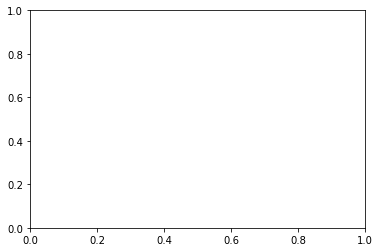

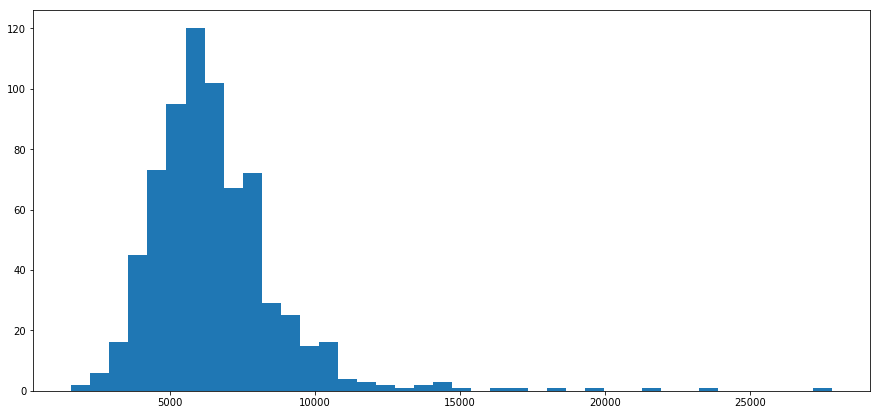

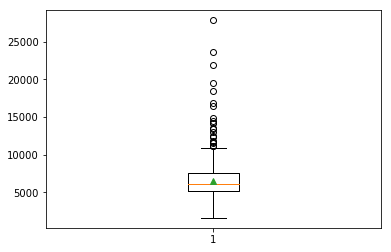

In [112]:
# Histogram of genau word duration
#genau_dauer = [ float(x)*0.0625 for x in genau_dauer]
plt.figure(figsize=(15, 7))
plt.hist(genau_dauer, bins = 40)
plt.show()

# Boxplot of genau word duration
plt.boxplot(genau_dauer, showmeans=True)
plt.show()

In [11]:
# Sort value list of the word_dict
from operator import itemgetter
def sort_w_dict(word):
    l = word_dict[word]
    l_gr = [l[i:i+3] for i in range(0, len(l),3)] # transform list in list of 3-elem-lists
    l_sorted = sorted(l_gr,key=itemgetter(1))
    lf_sorted=[]
    for i in range(len(l_sorted)):    # flatten sorted list
        lf_sorted += l_sorted[i]
    return lf_sorted
print(sort_w_dict("Arbeitstreffen"))

['g312acn1_002_AJP.par', 8949, ['a', 959, 'r', 479, 'b', 479, 'aI', 1279, 't', 479, 's', 479, 't', 799, 'r', 799, 'E', 959, 'f', 1279, 'n', 959], 'g313acn1_002_AJP.par', 10868, ['a', 1439, 'r', 1279, 'b', 959, 'aI', 1119, 't', 479, 's', 799, 't', 479, 'r', 959, 'E', 959, 'f', 1119, '@', 639, 'n', 639], 'g222acn2_004_AHS.par', 11029, ['a', 2079, 'r', 479, 'b', 479, 'aI', 1119, 't', 799, 's', 639, 't', 1119, 'r', 1279, 'E', 1279, 'f', 1119, 'm', 639], 'g366acn2_007_AKR.par', 11509, ['a', 1599, 'r', 479, 'b', 479, 'aI', 1599, 't', 799, 's', 1119, 't', 639, 'r', 1119, 'E', 1439, 'f', 959, 'n', 1279], 'g446acn1_015_AMM.par', 11829, ['a', 1919, 'r', 479, 'b', 479, 'aI', 1279, 't', 799, 's', 1279, 't', 479, 'r', 1759, 'E', 959, 'f', 1279, 'n', 1119], 'g009acn2_001_ABD.par', 11988, ['Q', 1439, 'a', 479, 'r', 479, 'b', 799, 'aI', 2079, 't', 479, 's', 799, 't', 959, 'r', 1279, 'E', 799, 'f', 1919, 'n', 479], 'g451acn2_023_AMN.par', 12308, ['Q', 1279, 'a', 799, 'r', 479, 'b', 1119, 'aI', 1439, 't

In [12]:
# Two lists (word_durations_list and phoneme_durations_in_word as list of lists) for given list of words
def multiple_word_stats(word_list):
    w_duration_list = []
    w_sounds_lists = []
    for word in word_list:
        w_duration_list = sort_w_dict(word)[1::3]
        w_sounds_lists = sort_w_dict(word)[2::3]
    return w_duration_list, w_sounds_lists

In [13]:
w_duration_list, w_sounds_lists = multiple_word_stats(["Arbeitstreffen"])
print(w_duration_list)

[8949, 10868, 11029, 11509, 11829, 11988, 12308, 12948, 13909, 14548, 14708, 15188, 15188, 15348, 16309, 17107, 23189]


In [46]:
# Prepare word sound plot for GENAU using the word choice dict, and w_dur = 6076
# Lists to use when creating the phoneme dictionary for "genau"
# 1. word_durations_list ([w_dur1, w_dur2, w_dur3, ...]) and 
# 2. phoneme_durations_in_word as list of lists: 
#    Looks like: [["a", phon_dur1, "r", phon_dur1, ...], ["a", phon_dur2, "r", phon_dur2, ...]]
# genau_median_sounds = list of lists for the phonemes in word GENAU of duration = 6076, no alternative pronounciations
genau_wdur, genau_sounds = multiple_word_stats(["genau"])
genau_median_sounds = []
x1 = 0
for el in genau_wdur:
    if el == 6076:
        if "j" not in genau_sounds[x1]:
            genau_median_sounds.append(genau_sounds[x1])
        elif "e:" not in genau_sounds[x1]:
            genau_median_sounds.append(genau_sounds[x1])
#        if genau_sounds[x1][genau_sounds[x1].index("@")+1] > 3400:
#            print(word_dict["genau"][x1*3])
    x1 +=1
        #print(word_dict["genau"][genau_wdur.index(el)*3])

In [16]:
# prepare the lists for the stacked bar chart for GENAU
g, schwa, n, au = [], [], [], []
x2 = 0
for el in genau_median_sounds:
    if x2 <11:
        g.append(el[1])
        schwa.append(el[3])
        n.append(el[5])
        au.append(el[7])
    x2 += 1
g = np.array(g)
schwa = np.array(schwa)
n = np.array(n)
au = np.array(au)
print(g)
print(schwa)

[ 959 1279  959  479  479  799  959 1119 1279  799  959]
[ 479  799 1119  479 1119  479 1119 3839  479 1119  639]


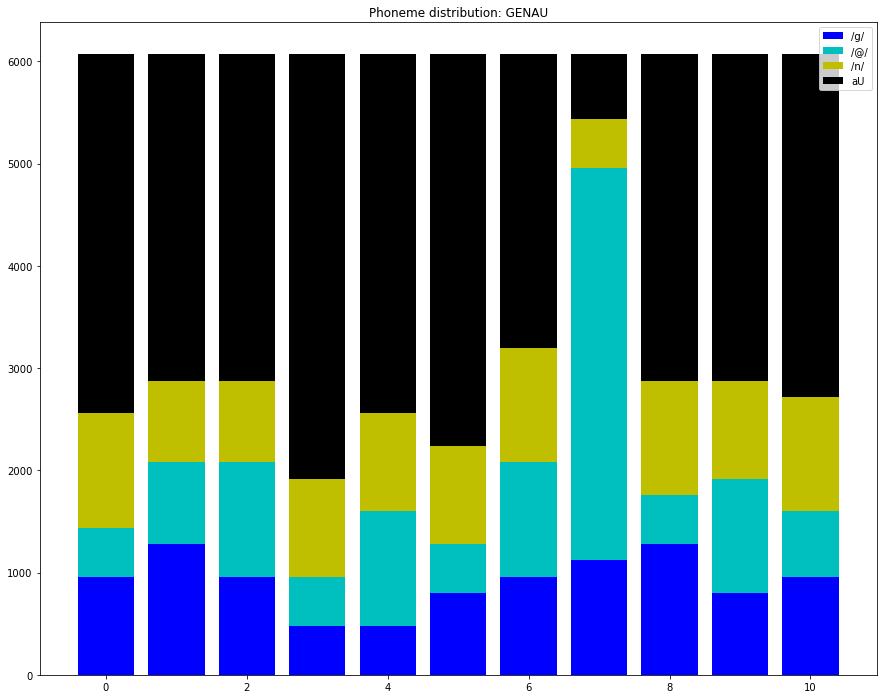

In [17]:
# Plot the stacked bar chart for GENAU of length 6076, first 10 occurences
X = range(11)
plt.figure(figsize=(15, 12))
plt.bar(X, g, label="/g/", color = "b")
plt.bar(X, schwa, label="/@/", bottom=g, color = "c")
plt.bar(X, n, label="/n/", bottom=g+schwa, color = "y")
plt.bar(X, au, label="aU", bottom=g+schwa+n, color = "k")
plt.title("Phoneme distribution: GENAU")
plt.legend()
plt.show()

In [140]:
# Prepare word sound plot using the word choice dict (here: Arbeitstreffen)
atref_wdur, atref_sounds = multiple_word_stats(["Arbeitstreffen"])
#atref_wdur = [x*0.0000625 for x in atref_wdur]
a_list, r_list, b_list, ai_list, t_list, s_list, E_list, f_list, n1_list1=[], [], [], [], [], [], [], [], []
a = 0
for el in atref_wdur:
    a_list.append(atref_sounds[a][1])
    for elem in atref_sounds[a]:
        x = 0
        if elem == "r":
            r_list.append(atref_sounds[a][x+1])
        x += 1
    b_list.append(atref_sounds[a][5])
    ai_list.append(atref_sounds[a][7])
    for elem in atref_sounds[a]:
        x = 0
        if elem == "t":
            t_list.append(atref_sounds[a][x+1])
        x += 1
    s_list.append(atref_sounds[a][13])
    if "E" in atref_sounds[a]:
        E_list.append(atref_sounds[a][atref_sounds[a].index("E")+1])
    if "f" in atref_sounds[a]:
        f_list.append(atref_sounds[a][atref_sounds[a].index("f")+1])
    if "n" in atref_sounds[a]:
        n1_list1.append(atref_sounds[a][atref_sounds[a].index("n")+1])
    a += 1

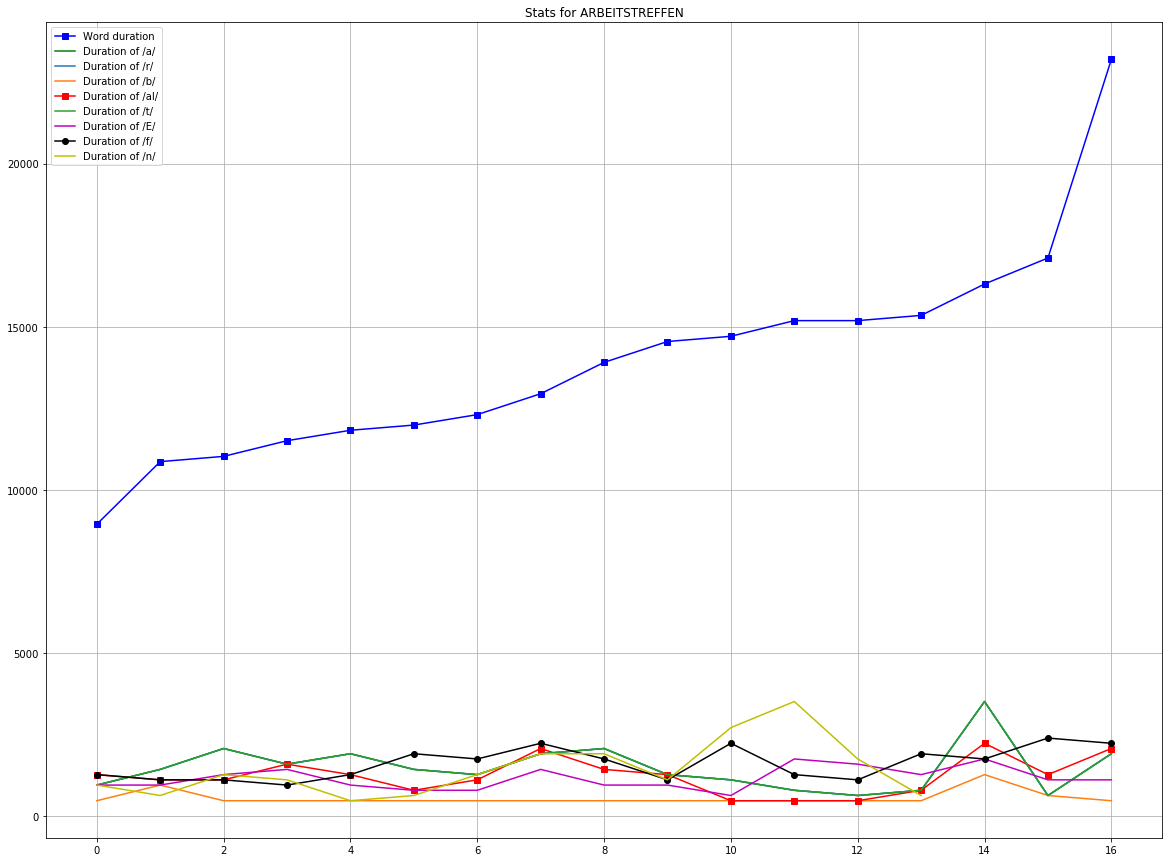

In [146]:
# Plot sound durations against the word duration for "Arbeitstreffen"
plt.figure(figsize=(20, 15))
plt.grid(True)
plt.plot(atref_wdur, label="Word duration", marker="s", color="b")
plt.plot(a_list, label="Duration of /a/", color="g")
plt.plot(r_list[::2], label="Duration of /r/")
plt.plot(b_list, label="Duration of /b/")
plt.plot(ai_list, label="Duration of /aI/", marker="s", color="r")
plt.plot(t_list[1::2], label="Duration of /t/")
plt.plot(E_list, label="Duration of /E/", color="m")
plt.plot(f_list, label="Duration of /f/", marker="o", color="k")
plt.plot(n1_list1, label="Duration of /n/", color = "y")
plt.title('Stats for ARBEITSTREFFEN')
plt.legend()
plt.show()

In [18]:
# Prepare word sound plot using the word choice dict (here: genau)
genau_wdur, genau_sounds = multiple_word_stats(["genau"])
genau_wdur = [ round(x*0.0000625, 4) for x in genau_wdur]
#print(genau_wdur)
g_list, schwa_list, n_list, au_list = [], [], [], []
l =[]
a = 0
for el in genau_wdur:
#    l.append(len(atref_sounds[a]))
#    print(l)
#    print(atref_sounds[a])
    g_list.append(genau_sounds[a][1])
    if ("@" or "e:") in genau_sounds[a]:
        schwa_list.append(genau_sounds[a][3])
    else:
        schwa_list.append(0)
    n_list.append(genau_sounds[a][genau_sounds[a].index("n")+1])
    if "aU" in genau_sounds[a]:
        au_list.append(genau_sounds[a][genau_sounds[a].index("aU")+1])
    else:
        au_list.append(0)
    a += 1
g_list = [round(x*0.0000625, 4) for x in g_list]
schwa_list = [round(x*0.0000625, 4) for x in schwa_list]
n_list = [ round(x*0.0000625, 4) for x in n_list]
au_list = [round(x*0.0000625, 4) for x in au_list]

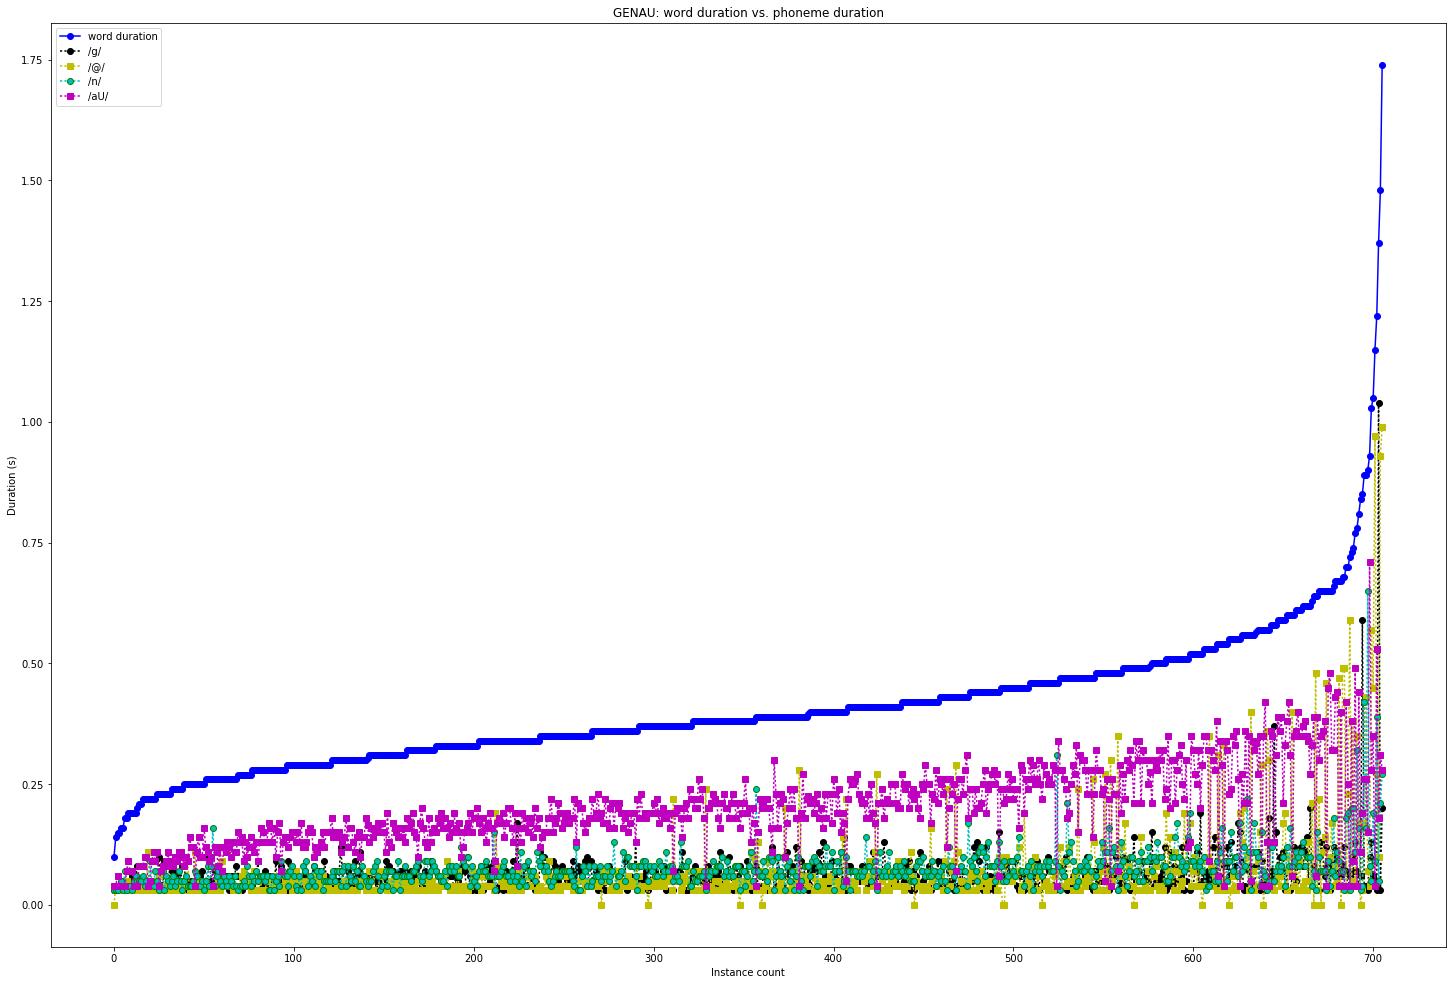

In [23]:
# Plot sound durations against the word duration for GENAU, in order of increasing word duration
x = range(706)
plt.figure(figsize=(25, 17))
plt.plot(x, genau_wdur, label = "word duration", marker="o", color = "b" )
plt.plot(x, g_list, label = "/g/", marker="o", mec = "k", linestyle = ":", color = "k")
plt.plot(x, schwa_list, label = "/@/", marker="s", linestyle = ":", color = "y")
plt.plot(x, n_list, label = "/n/", marker="o", mec = "g", linestyle = ":", color = "c")
plt.plot(x, au_list, label = "/aU/", marker="s", linestyle = ":", color = "m")
#plt.xlabel('count')
plt.ylabel('Duration (s)')
plt.xlabel("Instance count")
plt.title('GENAU: word duration vs. phoneme duration')
plt.legend()
plt.savefig('C:/Users/alexutza_a/Abschlussarbeit/Stats_for_genau.eps', format='eps', dpi=1200)
plt.show()
#col_labels = ["word_duration", "longest sound", "max duration"]
#table(cellText = genau_max_list, colLabels = col_labels, ax = "center")

In [190]:
# Prepare word sound plot using the word choice dict (here: genau)
fliegen_wdur, fliegen_sounds = multiple_word_stats(["fliegen"])
print(fliegen_sounds[0])
print(len(fliegen_wdur))
#print(genau_wdur)
f1_list, l_list, li_list, g1_list, schwa1_list, n2_list = [], [], [], [], [], []
l =[]
a = 0
for el in fliegen_wdur:
#    l.append(len(atref_sounds[a]))
#    print(l)
#    print(atref_sounds[a])
    f1_list.append(fliegen_sounds[a][1])
    l_list.append(fliegen_sounds[a][3])
    li_list.append(fliegen_sounds[a][5])
    g1_list.append(fliegen_sounds[a][7])
    if ("@" or "e:") in fliegen_sounds[a]:
        schwa1_list.append(fliegen_sounds[a][9])
    else:
        schwa1_list.append(0)
    if "n" in fliegen_sounds[a]:
        n2_list.append(fliegen_sounds[a][fliegen_sounds[a].index("n")+1])
    elif "N" in fliegen_sounds[a]:
        n2_list.append(fliegen_sounds[a][fliegen_sounds[a].index("N")+1])
    else:
        n2_list.append(0)
    a += 1

['f', 479, 'l', 479, 'i:', 639, 'g', 479, 'N', 639]
336


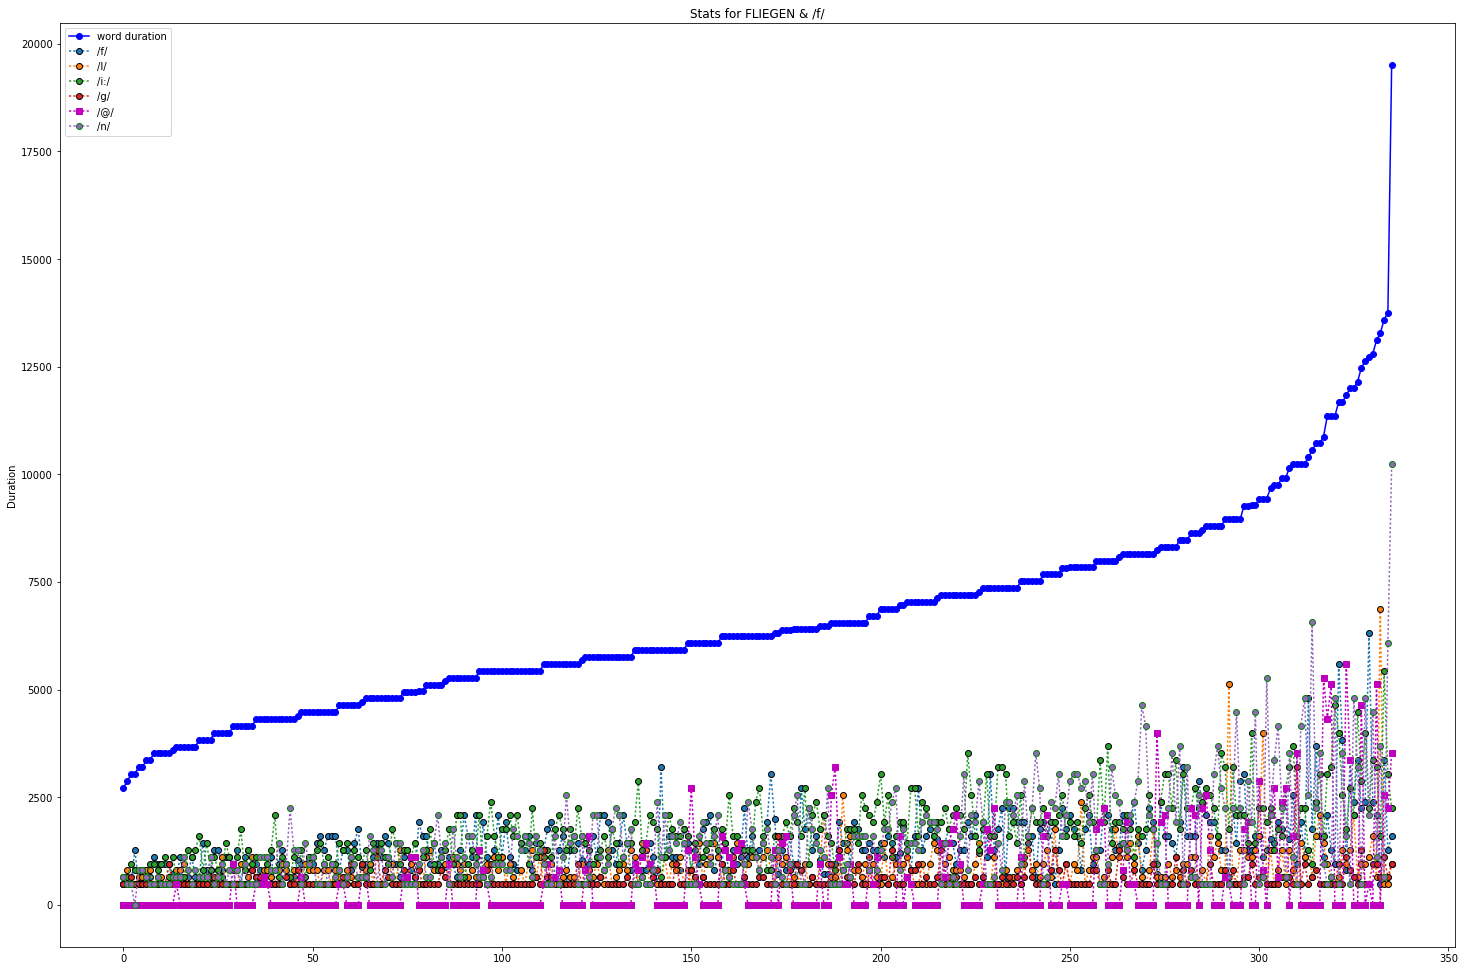

In [205]:
# Plot sound durations against the word duration for fliegen, in order of increasing word duration
x = range(336)
plt.figure(figsize=(25, 17))
plt.plot(x, fliegen_wdur, label = "word duration", marker="o", color = "b" )
plt.plot(x, f1_list, label = "/f/", marker="o", mec = "k", linestyle = ":")
plt.plot(x, l_list, label = "/l/", marker="o", mec = "k", linestyle = ":")
plt.plot(x, li_list, label = "/i:/", marker="o", mec = "k", linestyle = ":")
plt.plot(x, g1_list, label = "/g/", marker="o", mec = "k", linestyle = ":")
plt.plot(x, schwa1_list, label = "/@/", marker="s", mec = "m", linestyle = ":", color = "m")
plt.plot(x, n2_list, label = "/n/", marker="o", mec = "g", linestyle = ":")
#plt.xlabel('count')
plt.ylabel('Duration')
plt.title('Stats for FLIEGEN & /f/')
plt.legend()
plt.show()

In [21]:
# Lists to use when creating the phoneme dictionary for "Arbeitstreffen"
# 1. word_durations_list ([w_dur1, w_dur2, w_dur3, ...]) and 
# 2. phoneme_durations_in_word as list of lists: 
#    Looks like: [["a", phon_dur1, "r", phon_dur1, ...], ["a", phon_dur2, "r", phon_dur2, ...]]
atref_w_durL, atref_sounds_ls = multiple_word_stats(["Arbeitstreffen"])

In [22]:
# Arbeitstreffen: Create lists to build a stacked bar chart of phoneme distribution in word per w_duration
a, r1, b, ai, t1, s, t2, r2, E, f = [], [], [], [], [], [],[], [], [], []
for el in atref_sounds_ls:
    a.append(el[1])
    r1.append(el[3])
    b.append(el[5])
    ai.append(el[7])
    t1.append(el[9])
    s.append(el[11])
    t2.append(el[13])
    r2.append(el[15])
    E.append(el[17])
    f.append(el[19])
a = np.array(a)
r1 = np.array(r1)
b = np.array(b)
ai = np.array(ai)
t1 = np.array(t1)
s = np.array(s)
t2 = np.array(t2)
r2 = np.array(r2)
E = np.array(E)
f = np.array(f)

In [207]:
# Plot the stacked bar chart for "Arbeitstreffen"
X = range(17)
plt.figure(figsize=(15, 12))
plt.bar(X, a, label="/a/", color = "b")
plt.bar(X, ai, label="/aI/", bottom=a, hatch='//', color="b")
plt.bar(X, E, label="/E/", bottom=a+ai, hatch='\\', color="b")
plt.bar(X, b, label="/b/", bottom=a+ai+E, color="c")
plt.bar(X, t1, label="/t1/", bottom=a+ai+E+b, hatch='//', color="c")
plt.bar(X, t2, label="/t2/", bottom=a+ai+E+b+t1, hatch='//', color="c")
plt.bar(X, r1, label="/r1/", bottom=a+ai+E+b+t1+t2, color="y")
plt.bar(X, r2, label="/r2/", bottom=a+ai+E+b+t1+t2+r1, color="y")
plt.bar(X, s, label="/s/", bottom=a+ai+E+b+t1+t2+r1+r2, color="r")
plt.bar(X, f, label="/f/", bottom=a+ai+E+b+t1+t2+r1+r2+s, hatch="x", color="r")
plt.title("Phoneme distribution: ARBEITSTREFFEN")
plt.legend()
plt.show()

ValueError: incompatible sizes: argument 'height' must be length 17 or scalar

In [30]:
# Dictionary of phonemes in word "genau"
# Looks like: {"g" : [sound_dur1, w_dur1, sound_dur2, w_dur2, ...], "@" : [sound_dur1, w_dur1, sound_dur2, w_dur2, ...]...}
except_list = []
def create_word_phon_dict(w_dur_list, sound_lists):
	wordSound_dict = defaultdict(list)
	k = 0
	for el in sound_lists:
		el_phones = el[::2]
		el_durations = el[1::2]
#		if "m" in el:
#			print(el)
#			except_list.append(sound_lists.index(el))
#		elif "N" in el:
#			print(el)
#			except_list.append(sound_lists.index(el))
#		elif "@" in el:
#			print(el)
#			except_list.append(sound_lists.index(el))
		i = 0
		for phone in el_phones:
			wordSound_dict[phone].append(el_durations[i])
			wordSound_dict[phone].append(genau_dauer[k])
			i += 1
		k += 1
	return wordSound_dict
wordSound_dict = create_word_phon_dict(genau_dauer, sound_lists)

In [25]:
# Dictionary of phonemes in all occur. of "Arbeitstreffen"
# Looks like: {"a" : [sound_dur1, w_dur1, sound_dur2, w_dur2, ...], "r" : [sound_dur1, w_dur1, sound_dur2, w_dur2, ...]...}
atref_dict = create_word_phon_dict(atref_w_durL, atref_sounds_ls)
print(len(atref_dict["aI"][1::2]))
print(len(atref_dict["m"][1::2]))
print(len(atref_dict["N"][1::2]))
print(len(atref_dict["Q"][1::2]))
print(len(atref_dict["@"][1::2]))
print(len(atref_dict["f"][1::2]))

17
2
1
8
3
17


In [26]:
# Rare variations with /m/, /N/, /@/ check said it's real!
print(except_list[-6:])
for el in except_list[-6:]:
    print(word_dict["Arbeitstreffen"][el*3])

[]


In [27]:
# Extreme long e: -> check said it's real!
print(word_dict["genau"][547*3])

g411acn1_045_ALR.par


In [27]:
# List of proportions of given phoneme in "genau", expressed as phon_dur/word_dur
def get_genau_propLists(phoneme):
    sound_dur_list = wordSound_dict[phoneme][::2]
    w_dur_list = wordSound_dict[phoneme][1::2]
    proportions_list = []
#    print(phoneme + " " + str(min(sound_dur_list)))
#    print(phoneme + " " + str(np.median(sound_dur_list)))
#    print(phoneme + " " + str(np.mean(sound_dur_list)))
#    print(phoneme + " " + str(max(sound_dur_list)))
    for el in sound_dur_list:
        proportions_list.append(round(el/w_dur_list[sound_dur_list.index(el)], 2))
    return proportions_list

In [28]:
# List of proportions of given phoneme in "genau", expressed as phon_dur/word_dur for given duration
def get_genau_propLists_fw(phoneme, w_duration):
    sound_dur_list = wordSound_dict[phoneme][::2]
    w_dur_list = wordSound_dict[phoneme][1::2]
    proportions_list_fw = []
#    print(phoneme + " " + str(min(sound_dur_list)))
#    print(phoneme + " " + str(np.median(sound_dur_list)))
#    print(phoneme + " " + str(np.mean(sound_dur_list)))
#    print(phoneme + " " + str(max(sound_dur_list)))
    i0 = 0
    for el in sound_dur_list:
        if w_dur_list[i0] == w_duration:
            proportions_list_fw.append(round(el/w_dur_list[sound_dur_list.index(el)], 2))
        i0 += 1
    return proportions_list_fw

In [35]:
# List of lists of proportions for all phonemes in "Arbeitstreffen"
proportion_lists_atref = []
print(atref_dict.keys())
for phone in atref_dict.keys():
    proportion_lists_atref.append(get_atref_propLists(phone)) 

dict_keys(['a', 'r', 'b', 'aI', 't', 's', 'E', 'f', 'm', 'n', 'Q', '@', 'N'])


In [31]:
# List of lists of proportions for all phonemes in "genau"
proportion_lists_genau = []
for phone in wordSound_dict.keys():
    proportion_lists_genau.append(get_genau_propLists(phone)) 
for i in range(6):
    print(len(proportion_lists_genau[i]))
    i += 1

700
689
706
706
5
16


In [25]:
# List of lists of proportions for all phonemes in "genau" for given word duration
def prop_lists_fw_genau(w_duration):
    proportion_lists_genau_fw = []
    for phone in wordSound_dict.keys():
        proportion_lists_genau_fw.append(get_genau_propLists_fw(phone, w_duration)) 
    return proportion_lists_genau_fw
#    for j in range(6):
#        print(len(proportion_lists_genau_fw[j]))
#        j += 1

In [206]:
# Proportion distribution for phonemes in word "genau". Data prep for display in table.
genau_stat_matrix = []
y0 =0
for phoneme in wordSound_dict.keys():
    l = []
    l.append(phoneme)
    l.append(min(proportion_lists_genau[y0]))
    l.append(Decimal(np.median(proportion_lists_genau[y0])).quantize(TWOPLACES))
    l.append(Decimal(np.mean(proportion_lists_genau[y0])).quantize(TWOPLACES))
    l.append(max(proportion_lists_genau[y0]))
    genau_stat_matrix.append(l)
    y0 += 1
genau_stat_matrix.insert(0, ["Phoneme", "Min proportion", "Median proportion", "Mean proportion", "Max proportion"])
print(genau_stat_matrix)

[['Phoneme', 'Min proportion', 'Median proportion', 'Mean proportion', 'Max proportion'], ['g', 0.02, Decimal('0.17'), Decimal('0.16'), 0.37], ['@', 0.07, Decimal('0.09'), Decimal('0.15'), 0.84], ['n', 0.11, Decimal('0.18'), Decimal('0.18'), 0.72], ['aU', 0.1, Decimal('0.52'), Decimal('0.49'), 0.76], ['j', 0.11, Decimal('0.64'), Decimal('0.47'), 0.76], ['e:', 0.2, Decimal('0.26'), Decimal('0.28'), 0.76]]


In [38]:
# Create a table of phoneme proportions in "genau" using plotly
genau_table = ff.create_table(genau_stat_matrix)
py.iplot(genau_table, filename='GENAU proportion stats')

In [39]:
# Proportion distribution for phonemes in word "Arbeitstreffen". Data prep for display in table.
atref_stat_matrix = []
y =0
for phoneme in atref_dict.keys():
    l = []
    l.append(phoneme)
    l.append(min(proportion_lists_atref[y]))
    l.append(Decimal(np.median(proportion_lists_atref[y])).quantize(TWOPLACES))
    l.append(Decimal(np.mean(proportion_lists_atref[y])).quantize(TWOPLACES))
    l.append(max(proportion_lists_atref[y]))
    atref_stat_matrix.append(l)
    y += 1
atref_stat_matrix.insert(0, ["Phoneme", "Min proportion", "Median proportion", "Mean proportion", "Max proportion"])
print(atref_stat_matrix)

[['Phoneme', 'Min proportion', 'Median proportion', 'Mean proportion', 'Max proportion'], ['a', 0.06, Decimal('0.26'), Decimal('0.25'), 0.76], ['r', 0.04, Decimal('0.08'), Decimal('0.12'), 0.31], ['b', 0.04, Decimal('0.07'), Decimal('0.09'), 0.17], ['aI', 0.06, Decimal('0.27'), Decimal('0.24'), 0.48], ['t', 0.07, Decimal('0.10'), Decimal('0.12'), 0.21], ['s', 0.09, Decimal('0.15'), Decimal('0.15'), 0.22], ['E', 0.03, Decimal('0.16'), Decimal('0.21'), 0.43], ['f', 0.12, Decimal('0.24'), Decimal('0.23'), 0.32], ['m', 0.15, Decimal('0.81'), Decimal('0.81'), 1.48], ['n', 0.03, Decimal('0.20'), Decimal('0.24'), 0.96], ['Q', 0.05, Decimal('0.14'), Decimal('0.15'), 0.24], ['@', 0.03, Decimal('0.11'), Decimal('0.13'), 0.25], ['N', 0.76, Decimal('0.76'), Decimal('0.76'), 0.76]]


In [40]:
# Create a table of phoneme proportions in "Arbeitstreffen" using plotly

atref_table = ff.create_table(atref_stat_matrix)
py.iplot(atref_table, filename='Arbeitstreffen proportion stats')

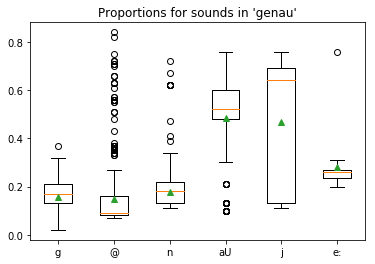

In [41]:
# Boxplot overview of phoneme proportions in word: genau
plt.boxplot(proportion_lists_genau, labels = wordSound_dict.keys(), showmeans=True)
plt.title("Proportions for sounds in 'genau'")
plt.show()

Count words with given length: 35


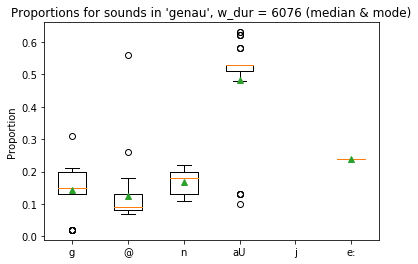

In [210]:
# Boxplot overview of phoneme proportions in word: genau, w_dur = 6076 (median)
print("Count words with given length: " + str(len(prop_lists_fw_genau(6076)[0])))
plt.boxplot(prop_lists_fw_genau(6076), labels = wordSound_dict.keys(), showmeans=True)
plt.ylabel("Proportion")
plt.title("Proportions for sounds in 'genau', w_dur = 6076 (median & mode)")
plt.show()

Count words with given length: 20


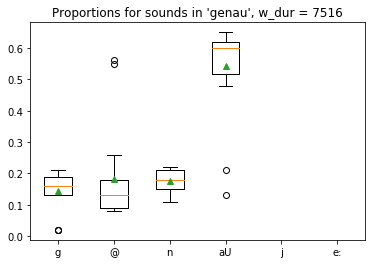

In [104]:
# Boxplot overview of phoneme proportions in word: genau, w_dur = 8316
print("Count words with given length: " + str(len(prop_lists_fw_genau(7516)[0])))
plt.boxplot(prop_lists_fw_genau(7516), labels = wordSound_dict.keys(), showmeans=True)
plt.title("Proportions for sounds in 'genau', w_dur = 7516")
plt.show()

Count words with given length: 25


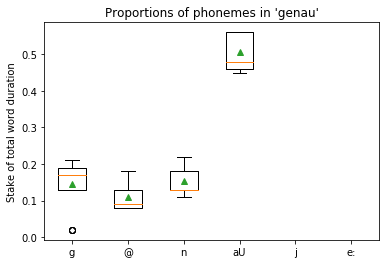

In [36]:
# Boxplot overview of phoneme proportions in word: genau, w_dur = 4636
print("Count words with given length: " + str(len(prop_lists_fw_genau(4636)[0])))
plt.boxplot(prop_lists_fw_genau(4636), labels = ["g", "@", "n", "aU", "j", "e:"], showmeans=True)
plt.ylabel("Stake of total word duration")
plt.title("Proportions of phonemes in 'genau'") #, w_dur = 4636"
plt.savefig('C:/Users/alexutza_a/Abschlussarbeit/Sound_boxplot_genau.eps', format='eps', dpi=1200)
plt.show()

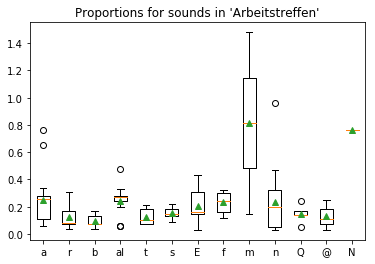

In [42]:
# Boxplot overview of phoneme proportions in word: Arbeitstreffen
plt.boxplot(proportion_lists_atref, labels = atref_dict.keys(), showmeans=True)
plt.title("Proportions for sounds in 'Arbeitstreffen'")
plt.show()

In [208]:
w_dict = open("C:/Users/alexutza_a/Abschlussarbeit/word_dict.txt", "w")
w_dict.write(str(word_dict))
w_dict.close()